<a href="https://colab.research.google.com/github/Gangneng/pytorch_tutorial/blob/main/pytorch_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/KDT/파이토치_튜토리얼

Mounted at /content/drive
/content/drive/MyDrive/KDT/파이토치_튜토리얼


pytorch에서 제공해주는 미리 학습된 모델들을 활용하여 각 모델의 성능을 비교하여 보자.

In [18]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
densenet = models.densenet161(pretrained=True)

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) #state_dict()는 모델의 하이퍼 파라미터 정보가 포함되어 있는 사전 객체이다.
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

각 모델들을 전부 이용하여 학습해보자.

* resnet18
* alexnet 
* vgg16 
* densenet 

학습 데이터 및 학습 방법 등 기타 설정 등은 Transfer learning for computer vision tutorial과 동일하게 설정하였다.

# Resnet

In [19]:
resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [20]:
resnet18 = train_model(resnet18, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.6878 Acc: 0.6598
val Loss: 1.0611 Acc: 0.7059

Epoch 1/24
----------
train Loss: 0.8454 Acc: 0.6967
val Loss: 0.6130 Acc: 0.8366

Epoch 2/24
----------
train Loss: 0.7623 Acc: 0.7295
val Loss: 0.5482 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.8654 Acc: 0.7008
val Loss: 0.9767 Acc: 0.7124

Epoch 4/24
----------
train Loss: 0.6553 Acc: 0.7828
val Loss: 0.4012 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.6176 Acc: 0.7131
val Loss: 0.4116 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.5239 Acc: 0.8033
val Loss: 0.3244 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.4356 Acc: 0.8238
val Loss: 0.3023 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.3768 Acc: 0.8689
val Loss: 0.2682 Acc: 0.8758

Epoch 9/24
----------
train Loss: 0.3538 Acc: 0.8484
val Loss: 0.2489 Acc: 0.8889

Epoch 10/24
----------
train Loss: 0.3234 Acc: 0.8566
val Loss: 0.2820 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.2511 Acc: 0.9016
val Loss: 0.2818 Acc: 0.8824

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


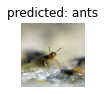

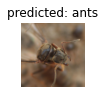

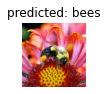

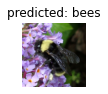

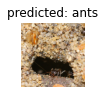

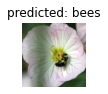

In [21]:
visualize_model(resnet18)

# Alexnet

In [15]:
alexnet = alexnet.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
alexnet = train_model(alexnet, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 2.9910 Acc: 0.5287
val Loss: 2.0470 Acc: 0.6405

Epoch 1/24
----------
train Loss: 1.5962 Acc: 0.5164
val Loss: 1.6166 Acc: 0.4967

Epoch 2/24
----------
train Loss: 1.2191 Acc: 0.5533
val Loss: 0.7472 Acc: 0.4967

Epoch 3/24
----------
train Loss: 0.8288 Acc: 0.6311
val Loss: 0.9302 Acc: 0.6078

Epoch 4/24
----------
train Loss: 0.8856 Acc: 0.6434
val Loss: 0.5572 Acc: 0.7255

Epoch 5/24
----------
train Loss: 0.7065 Acc: 0.7049
val Loss: 0.7523 Acc: 0.6601

Epoch 6/24
----------
train Loss: 0.5865 Acc: 0.7336
val Loss: 0.7023 Acc: 0.6797

Epoch 7/24
----------
train Loss: 0.4850 Acc: 0.7828
val Loss: 0.6394 Acc: 0.7190

Epoch 8/24
----------
train Loss: 0.4320 Acc: 0.8197
val Loss: 0.5691 Acc: 0.7582

Epoch 9/24
----------
train Loss: 0.4219 Acc: 0.8156
val Loss: 0.5548 Acc: 0.7647

Epoch 10/24
----------
train Loss: 0.3885 Acc: 0.8115
val Loss: 0.5326 Acc: 0.7582

Epoch 11/24
----------
train Loss: 0.3961 Acc: 0.7992
val Loss: 0.5380 Acc: 0.7712

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


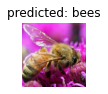

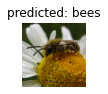

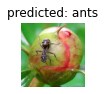

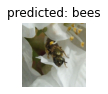

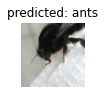

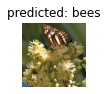

In [17]:
visualize_model(alexnet)

# VGGnet

In [22]:
vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: nan Acc: 0.4631
val Loss: nan Acc: 0.4575

Epoch 1/24
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 2/24
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 3/24
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 4/24
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 5/24
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 6/24
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 7/24
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 8/24
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 9/24
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 10/24
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 11/24
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 12/24
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 13/24
------

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


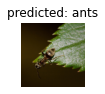

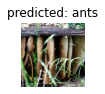

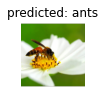

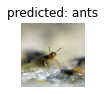

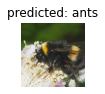

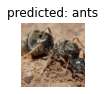

In [24]:
visualize_model(vgg16)

# DenseNet

In [25]:
densenet = densenet.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(densenet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [26]:
densenet = train_model(densenet, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.5647 Acc: 0.6311
val Loss: 1.0500 Acc: 0.7451

Epoch 1/24
----------
train Loss: 0.5944 Acc: 0.7664
val Loss: 0.8322 Acc: 0.8039

Epoch 2/24
----------
train Loss: 0.6247 Acc: 0.7787
val Loss: 0.2541 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.6223 Acc: 0.7254
val Loss: 0.4312 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.5046 Acc: 0.8115
val Loss: 0.2589 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3632 Acc: 0.8730
val Loss: 0.2975 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.5102 Acc: 0.8074
val Loss: 0.3428 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.3612 Acc: 0.8566
val Loss: 0.1986 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.2966 Acc: 0.8689
val Loss: 0.2140 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3113 Acc: 0.8525
val Loss: 0.2159 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2705 Acc: 0.8893
val Loss: 0.2063 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2411 Acc: 0.8730
val Loss: 0.2313 Acc: 0.9281

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


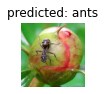

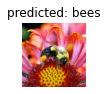

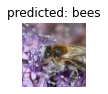

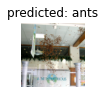

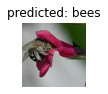

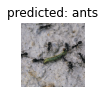

In [27]:
visualize_model(densenet)

각 모델별 최고 검증 정확도는 다음과 같다.

* Resnet : 90%
* Alexnet : 79%
* VGGnet : 45%
* Densenet : 94%

Densenet이 꿀벌과 개미 구분하는 모델로는 가장 적절하다는 것을 알 수 있었다.